In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.decomposition import PCA
from itertools import product

In [215]:
# Read in data
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/Cust_Segmentation.csv")
df

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2
...,...,...,...,...,...,...,...,...,...,...
845,846,27,1,5,26,0.548,1.220,NaN,NBA007,6.8
846,847,28,2,7,34,0.359,2.021,0.0,NBA002,7.0
847,848,25,4,0,18,2.802,3.210,1.0,NBA001,33.4
848,849,32,1,12,28,0.116,0.696,0.0,NBA012,2.9


In [216]:
# Drop null values
df = df.dropna()
df.isna().sum()

# Remove customer ID column
df = df.drop(columns=["Customer Id"])

In [217]:
# Extract numerical and categorical features
features_numerical = [feature for feature in df.columns if df[feature].dtype != "O"]
features_categorical = [feature for feature in df.columns if df[feature].dtype == "O"]

# ColumnTransformer to standardize and OneHotEncode our data set.
preprocess = ColumnTransformer([
    ("num", StandardScaler(), features_numerical),
    ("cat", OneHotEncoder(sparse_output=False), features_categorical),
])

# Create functions for both DBSCAN AND HDBSCAN that return pipeline objects to use in later functions
def pipeline_dbscan(eps, min_samples):
    return Pipeline([
        ("preprocess", preprocess),
        ("pca", PCA(n_components=2, random_state=0)),   # Don't have to use PCA here, just using it for practise.
        ("dbscan", DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")),
    ])

def pipeline_hdbscan(min_samples):
    return Pipeline([
        ("preprocess", preprocess),
        ("pca", PCA(n_components=2, random_state=0)),   # Don't have to use PCA here, just using it for practise.
        ("hdbscan", HDBSCAN(min_samples=min_samples, metric="euclidean")),
    ])

In [218]:
# Function to evaluate the performance of DBSCAN clustering
def evaluate_dbscan(eps, min_samples):
    # Train the DBSCAN pipeline
    dbscan_pipeline = pipeline_dbscan(eps, min_samples).fit(df)

    # Apply the ColumnTransformer first, then PCA
    X_trans = dbscan_pipeline["preprocess"].transform(df)
    X_pca = dbscan_pipeline["pca"].transform(X_trans)

    # Extract the labels for each datapoint
    labels = dbscan_pipeline["dbscan"].labels_

    # Noise points are assigned value -1. We should remove them before evaluation
    # since we do not want our evaluation metrics using the "Noise cluster" in its calculations
    mask = labels != -1
    labels_filtered = labels[mask]

    # Keep datapoints that belong to a cluster
    X_pca_filtered = X_pca[mask]

    # The evaluation metrics we're using are undefined if we have 0 or 1 clusters,
    # since they compare clusters to each other, this check ensures we have more than 1 cluster.
    if len(np.unique(labels_filtered)) > 1:
        return {
            "eps":eps,
            "min_samples":min_samples,
            "silhouette": metrics.silhouette_score(X_pca_filtered, labels_filtered),
            "calinski_harabasz": metrics.calinski_harabasz_score(X_pca_filtered, labels_filtered),
            "davies_bouldin": metrics.davies_bouldin_score(X_pca_filtered, labels_filtered),
        }
    else:
        return {
            "eps":eps,
            "min_samples":min_samples,
            "silhouette": -1,
            "calinski_harabasz": 0,
            "davies_bouldin": np.inf,
     }

# Function to evaluate the performance of HDBSCAN clustering
def evaluate_hdbscan(min_samples):
    # Train the HDBSCAN pipeline
    hdbscan_pipeline = pipeline_hdbscan(min_samples).fit(df)

    # Apply the ColumnTransformer first, then PCA
    X_trans = hdbscan_pipeline["preprocess"].transform(df)
    X_pca = hdbscan_pipeline["pca"].transform(X_trans)

    # Extract the labels for each datapoint
    labels = hdbscan_pipeline["hdbscan"].labels_

    # Create a mask where if the label is noise (value -1) it's false, and true otherwise
    mask = labels != -1

    # use mask Keep non-noise labels
    labels_filtered = labels[mask]

    # use mask to Keep datapoints that belong to a cluster
    X_pca_filtered = X_pca[mask]

    # For the same reason as DBSCAN, we perform this check
    if len(np.unique(labels_filtered)) > 1:
        return {
            "min_samples":min_samples,
            "silhouette": metrics.silhouette_score(X_pca_filtered, labels_filtered),
            "calinski_harabasz": metrics.calinski_harabasz_score(X_pca_filtered, labels_filtered),
            "davies_bouldin": metrics.davies_bouldin_score(X_pca_filtered, labels_filtered),
        }
    else:
        return {
            "min_samples":min_samples,
            "silhouette": -1,
            "calinski_harabasz": 0,
            "davies_bouldin": np.inf
     }

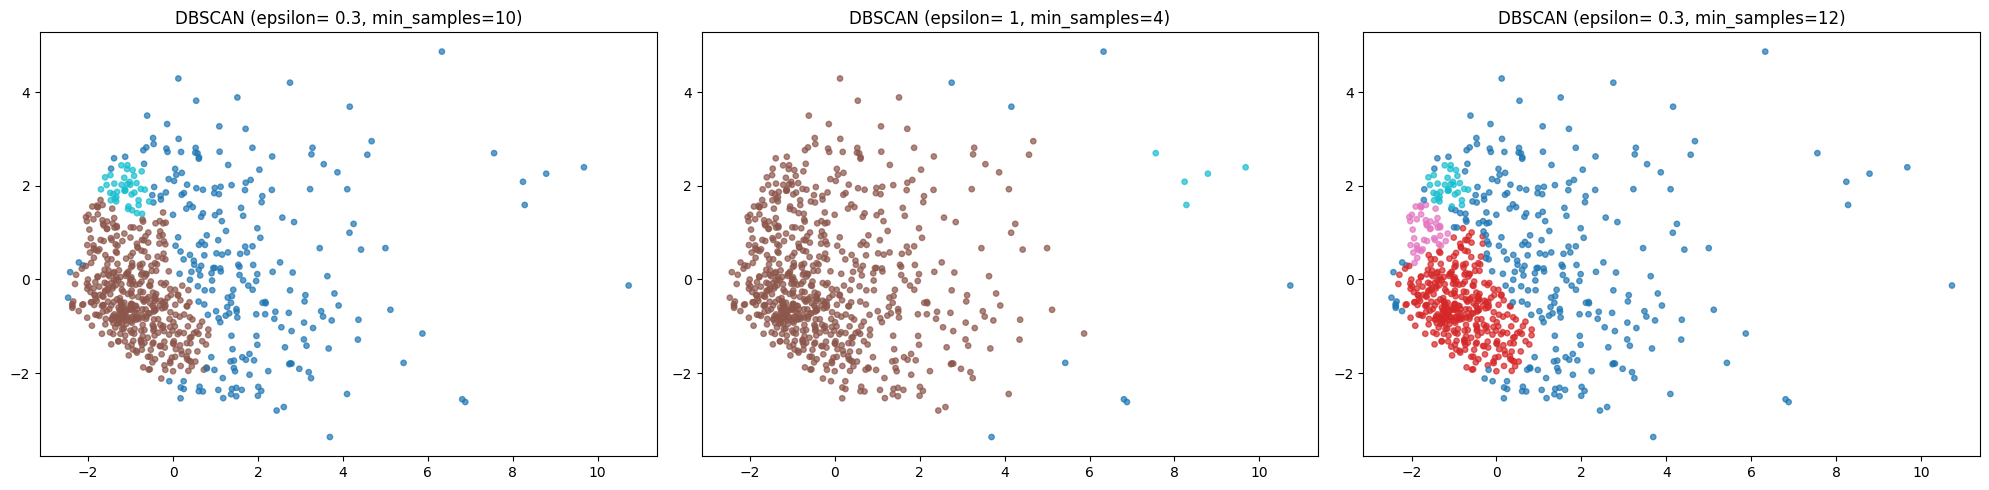

In [219]:
# Since we have already used PCA with 2 components, we can easily plot our clusters.

# Function to plot DBSCAN clusters.
def plot_dbscan(eps, min_samples, ax):
    # Extract the model from the pipeline
    dbscan_pipeline = pipeline_dbscan(eps, min_samples).fit(df)

    # Get the label of each point
    labels = dbscan_pipeline["dbscan"].labels_

    # Extract the dataset after preprocessing
    X_trans = dbscan_pipeline["preprocess"].transform(df)

    # Perform PCA on that dataset
    X_pca = dbscan_pipeline["pca"].transform(X_trans)

    # Plot the datapoints.
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10",s=15, alpha=0.7)
    ax.set_title(f"DBSCAN (epsilon= {eps}, min_samples={min_samples})")

# Create figure and 3 subplots (1 row, 3 columns)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for eps, min_samples, ax in zip([0.3, 1, 0.3], [10,4,12], ax):
    plot_dbscan(eps, min_samples, ax)

fig.tight_layout()

# The first plot is a good start, the second plot is an example of underclustering
# and the third plot has done a good job of finding some underlying patterns.

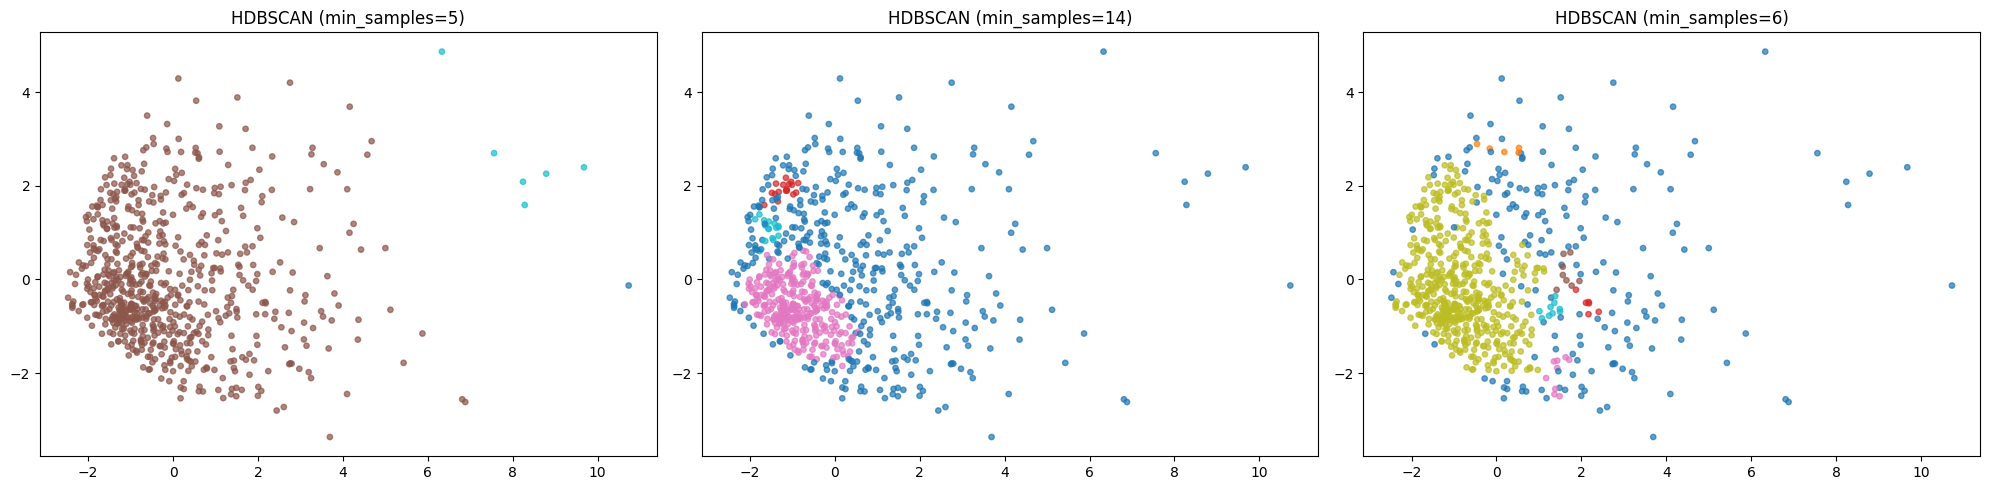

In [220]:
# Function to plot HDBSCAN clusters.
def plot_hdbscan(min_samples, ax):
    # Extract the model from the pipeline
    hdbscan_pipeline = pipeline_hdbscan(min_samples).fit(df)

    # Get the label of each point
    labels = hdbscan_pipeline["hdbscan"].labels_

    # Extract the dataset after preprocessing
    X_trans = hdbscan_pipeline["preprocess"].transform(df)

    # Perform PCA on that dataset
    X_pca = hdbscan_pipeline["pca"].transform(X_trans)

    # Plot the datapoints.
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10",s=15, alpha=0.7)
    ax.set_title(f"HDBSCAN (min_samples={min_samples})")

# Create figure and 3 subplots (1 row, 3 columns)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for min_samples, ax in zip([5,14,6], ax):
    plot_hdbscan(min_samples, ax)

fig.tight_layout()

In [221]:
# Evaluate DBSCAN for the cartesian product of epsilon=0.1,...,1, and minpoints=1,...,14
results_dbscan = pd.DataFrame([evaluate_dbscan(eps, ms) for eps, ms in product(np.arange(0.1, 1, 0.1), range(1,15))])
results_dbscan = results_dbscan.sort_values(by=["silhouette"], ascending=False)

# Evaluate HDBSCAN for minpoints=1,...,14
results_hdbscan = pd.DataFrame([evaluate_hdbscan(ms) for ms in (range(2,15))])
results_hdbscan = results_hdbscan.sort_values(by=["silhouette"], ascending=False)

results_hdbscan
# After analysing both the DBSCAN AND HDBSCAN results, I would go with HBDSCAN with min_samples = 6.
# Although it's evaluation benchmarks good but not the best, when analysing it visually, it identifies
# underlying patterns in our data better than DBSCAN and other min_sample values.

,min_samples,silhouette,calinski_harabasz,davies_bouldin
3,5,0.698680,106.839862,0.348433
2,4,0.485076,95.263811,0.514158
1,3,0.481837,93.911649,0.516174
12,14,0.441664,128.411425,0.508794
11,13,0.431112,128.470567,0.530530
10,12,0.424010,143.586003,0.537894
0,2,0.370319,464.661389,0.708560
6,8,0.366321,58.431508,0.555633
9,11,0.340071,93.070770,0.533117
8,10,0.258709,58.262260,0.557314
